In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/india-stock-market/stocks_df.csv
/kaggle/input/india-stock-market/nse_indexes.csv
/kaggle/input/india-stock-market/indexes_df.csv


In [3]:
stocks_df= pd.read_csv("/kaggle/input/india-stock-market/stocks_df.csv")
nse_indexes_df= pd.read_csv("/kaggle/input/india-stock-market/nse_indexes.csv")
indexes_df= pd.read_csv("/kaggle/input/india-stock-market/indexes_df.csv")

In [4]:
stocks_df

,Date,Stock,Open,High,Low,Close,Volume,Change Pct
0,2013-01-02,20MICRONS,80.35,80.55,77.50,77.80,1088880,-3.23
1,2013-01-03,20MICRONS,78.58,79.78,76.00,76.40,590180,-1.80
2,2013-01-04,20MICRONS,76.50,77.25,75.50,75.83,380850,-0.75
3,2013-01-07,20MICRONS,76.88,78.00,74.00,74.90,1144204,-1.23
4,2013-01-08,20MICRONS,74.97,75.97,74.25,75.28,605020,0.51
...,...,...,...,...,...,...,...,...
4094382,2022-01-05,ZYDUSWELL,1868.80,1899.00,1850.40,1891.60,15559,1.50
4094383,2022-01-06,ZYDUSWELL,1891.60,1894.65,1864.80,1869.80,9201,-1.15
4094384,2022-01-07,ZYDUSWELL,1866.00,1879.00,1840.00,1844.65,27888,-1.35
4094385,2022-01-10,ZYDUSWELL,1850.25,1865.00,1840.10,1859.15,11310,0.79


In [5]:
nse_indexes_df

,Date,Index,Open,High,Low,Close,Volume,Currency
0,1995-11-06,NIFTY 50,1001.53,1001.53,988.92,988.92,0,INR
1,1995-11-07,NIFTY 50,987.17,987.17,977.05,978.22,0,INR
2,1995-11-08,NIFTY 50,976.28,976.28,962.98,964.01,0,INR
3,1995-11-09,NIFTY 50,960.32,960.32,952.13,953.07,0,INR
4,1995-11-10,NIFTY 50,951.93,951.93,946.00,948.82,0,INR
...,...,...,...,...,...,...,...,...
87531,2022-01-24,NIFTY GS COMPSITE,2345.57,2345.57,2342.80,2342.95,0,INR
87532,2022-01-25,NIFTY GS COMPSITE,2343.99,2346.21,2343.26,2343.60,0,INR
87533,2022-01-27,NIFTY GS COMPSITE,2344.42,2344.42,2334.43,2334.50,0,INR
87534,2022-01-28,NIFTY GS COMPSITE,2334.18,2335.28,2332.73,2333.30,0,INR


In [6]:
indexes_df.head()

,Symbol
0,NIFTY 50 Pre Open
1,NIFTY 50
2,NIFTY NEXT 50
3,NIFTY100 LIQ 15
4,NIFTY BANK


In [7]:
#doing for nifty_50

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# import yfinance as yf
try:
    import pandas_ta as ta
except:
    !pip install pandas_ta
    import pandas_ta as ta
# data = yf.download(tickers = '^RUI', start = '2012-03-11',end = '2022-07-10')
# data.head(10)




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218910 sha256=3bf00ec39f5cc952acdb2a4f5bc17b573720280f9e9b94954b065563141e422c
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [9]:
data_nifty_50_orig = nse_indexes_df[nse_indexes_df.Index=="NIFTY 50"]
data_nifty_50 = data_nifty_50_orig.copy()
data_nifty_50

,Date,Index,Open,High,Low,Close,Volume,Currency
0,1995-11-06,NIFTY 50,1001.53,1001.53,988.92,988.92,0,INR
1,1995-11-07,NIFTY 50,987.17,987.17,977.05,978.22,0,INR
2,1995-11-08,NIFTY 50,976.28,976.28,962.98,964.01,0,INR
3,1995-11-09,NIFTY 50,960.32,960.32,952.13,953.07,0,INR
4,1995-11-10,NIFTY 50,951.93,951.93,946.00,948.82,0,INR
...,...,...,...,...,...,...,...,...
6525,2022-01-24,NIFTY 50,17575.15,17599.40,16997.85,17149.10,323847008,INR
6526,2022-01-25,NIFTY 50,17001.55,17309.15,16836.80,17277.95,326516000,INR
6527,2022-01-27,NIFTY 50,17062.00,17182.50,16866.75,17110.15,395596992,INR
6528,2022-01-28,NIFTY 50,17208.30,17373.50,17077.10,17101.95,355284000,INR


In [10]:
data_nifty_50.describe()

,Open,High,Low,Close,Volume
count,6530.000000,6530.000000,6530.000000,6530.000000,6.530000e+03
mean,5162.617675,5196.435907,5121.463164,5159.604000,1.666071e+08
std,4132.122509,4147.340124,4106.751548,4127.589639,1.695505e+08
min,786.370000,805.820000,775.430000,788.150000,0.000000e+00
25%,1311.387500,1328.162500,1295.337500,1311.075000,5.405950e+07
50%,4612.775000,4653.375000,4555.850000,4609.100000,1.251255e+08
75%,8038.100000,8096.412500,7976.200000,8034.462500,2.023363e+08
max,18602.350000,18604.450000,18445.300000,18477.050000,1.810970e+09


In [11]:
data_nifty_50.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6530 entries, 0 to 6529
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      6530 non-null   object 
 1   Index     6530 non-null   object 
 2   Open      6530 non-null   float64
 3   High      6530 non-null   float64
 4   Low       6530 non-null   float64
 5   Close     6530 non-null   float64
 6   Volume    6530 non-null   int64  
 7   Currency  6530 non-null   object 
dtypes: float64(4), int64(1), object(3)
memory usage: 459.1+ KB


In [12]:
# Adding indicators
data_nifty_50['RSI']=ta.rsi(data_nifty_50.Close, length=15)
data_nifty_50['EMAF']=ta.ema(data_nifty_50.Close, length=20)
data_nifty_50['EMAM']=ta.ema(data_nifty_50.Close, length=100)
data_nifty_50['EMAS']=ta.ema(data_nifty_50.Close, length=150)


data_nifty_50['TargetNextClose'] = data_nifty_50['Close'].shift(-1)


In [13]:
data_nifty_50

,Date,Index,Open,High,Low,Close,Volume,Currency,RSI,EMAF,EMAM,EMAS,TargetNextClose
0,1995-11-06,NIFTY 50,1001.53,1001.53,988.92,988.92,0,INR,NaN,NaN,NaN,NaN,978.22
1,1995-11-07,NIFTY 50,987.17,987.17,977.05,978.22,0,INR,NaN,NaN,NaN,NaN,964.01
2,1995-11-08,NIFTY 50,976.28,976.28,962.98,964.01,0,INR,NaN,NaN,NaN,NaN,953.07
3,1995-11-09,NIFTY 50,960.32,960.32,952.13,953.07,0,INR,NaN,NaN,NaN,NaN,948.82
4,1995-11-10,NIFTY 50,951.93,951.93,946.00,948.82,0,INR,NaN,NaN,NaN,NaN,917.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6525,2022-01-24,NIFTY 50,17575.15,17599.40,16997.85,17149.10,323847008,INR,37.664739,17735.028498,17357.686035,16990.562156,17277.95
6526,2022-01-25,NIFTY 50,17001.55,17309.15,16836.80,17277.95,326516000,INR,41.188298,17691.497213,17356.107103,16994.368617,17110.15
6527,2022-01-27,NIFTY 50,17062.00,17182.50,16866.75,17110.15,395596992,INR,38.177215,17636.130811,17351.236666,16995.902145,17101.95
6528,2022-01-28,NIFTY 50,17208.30,17373.50,17077.10,17101.95,355284000,INR,38.031642,17585.256448,17346.300296,16997.306753,17316.65


In [14]:
data_nifty_50.dropna(inplace=True)
data_nifty_50

,Date,Index,Open,High,Low,Close,Volume,Currency,RSI,EMAF,EMAM,EMAS,TargetNextClose
149,1996-06-10,NIFTY 50,1136.86,1144.15,1136.86,1141.35,0,INR,62.720677,1104.252565,1030.999149,978.612667,1143.06
150,1996-06-11,NIFTY 50,1137.74,1145.68,1136.77,1143.06,0,INR,63.088494,1107.948511,1033.218176,980.790777,1163.87
151,1996-06-12,NIFTY 50,1164.83,1171.01,1163.58,1163.87,0,INR,67.295813,1113.274367,1035.805341,983.215667,1168.40
152,1996-06-13,NIFTY 50,1166.37,1172.34,1164.66,1168.40,0,INR,68.142732,1118.524428,1038.430978,985.668440,1196.06
153,1996-06-14,NIFTY 50,1169.26,1198.35,1169.26,1196.06,0,INR,72.757977,1125.908768,1041.552344,988.455083,1185.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6524,2022-01-21,NIFTY 50,17613.70,17707.60,17485.85,17617.15,277644992,INR,47.265526,17796.705182,17361.899894,16988.434131,17149.10
6525,2022-01-24,NIFTY 50,17575.15,17599.40,16997.85,17149.10,323847008,INR,37.664739,17735.028498,17357.686035,16990.562156,17277.95
6526,2022-01-25,NIFTY 50,17001.55,17309.15,16836.80,17277.95,326516000,INR,41.188298,17691.497213,17356.107103,16994.368617,17110.15
6527,2022-01-27,NIFTY 50,17062.00,17182.50,16866.75,17110.15,395596992,INR,38.177215,17636.130811,17351.236666,16995.902145,17101.95


In [15]:
data_nifty_50.drop(['Date', 'Index', 'Currency'], axis=1, inplace=True)
data_nifty_50

,Open,High,Low,Close,Volume,RSI,EMAF,EMAM,EMAS,TargetNextClose
149,1136.86,1144.15,1136.86,1141.35,0,62.720677,1104.252565,1030.999149,978.612667,1143.06
150,1137.74,1145.68,1136.77,1143.06,0,63.088494,1107.948511,1033.218176,980.790777,1163.87
151,1164.83,1171.01,1163.58,1163.87,0,67.295813,1113.274367,1035.805341,983.215667,1168.40
152,1166.37,1172.34,1164.66,1168.40,0,68.142732,1118.524428,1038.430978,985.668440,1196.06
153,1169.26,1198.35,1169.26,1196.06,0,72.757977,1125.908768,1041.552344,988.455083,1185.37
...,...,...,...,...,...,...,...,...,...,...
6524,17613.70,17707.60,17485.85,17617.15,277644992,47.265526,17796.705182,17361.899894,16988.434131,17149.10
6525,17575.15,17599.40,16997.85,17149.10,323847008,37.664739,17735.028498,17357.686035,16990.562156,17277.95
6526,17001.55,17309.15,16836.80,17277.95,326516000,41.188298,17691.497213,17356.107103,16994.368617,17110.15
6527,17062.00,17182.50,16866.75,17110.15,395596992,38.177215,17636.130811,17351.236666,16995.902145,17101.95


In [16]:
data_nifty_50.reset_index(inplace = True)
data_nifty_50

,index,Open,High,Low,Close,Volume,RSI,EMAF,EMAM,EMAS,TargetNextClose
0,149,1136.86,1144.15,1136.86,1141.35,0,62.720677,1104.252565,1030.999149,978.612667,1143.06
1,150,1137.74,1145.68,1136.77,1143.06,0,63.088494,1107.948511,1033.218176,980.790777,1163.87
2,151,1164.83,1171.01,1163.58,1163.87,0,67.295813,1113.274367,1035.805341,983.215667,1168.40
3,152,1166.37,1172.34,1164.66,1168.40,0,68.142732,1118.524428,1038.430978,985.668440,1196.06
4,153,1169.26,1198.35,1169.26,1196.06,0,72.757977,1125.908768,1041.552344,988.455083,1185.37
...,...,...,...,...,...,...,...,...,...,...,...
6375,6524,17613.70,17707.60,17485.85,17617.15,277644992,47.265526,17796.705182,17361.899894,16988.434131,17149.10
6376,6525,17575.15,17599.40,16997.85,17149.10,323847008,37.664739,17735.028498,17357.686035,16990.562156,17277.95
6377,6526,17001.55,17309.15,16836.80,17277.95,326516000,41.188298,17691.497213,17356.107103,16994.368617,17110.15
6378,6527,17062.00,17182.50,16866.75,17110.15,395596992,38.177215,17636.130811,17351.236666,16995.902145,17101.95


In [17]:
data_nifty_50.drop(['index'], axis=1, inplace = True)
data_nifty_50

,Open,High,Low,Close,Volume,RSI,EMAF,EMAM,EMAS,TargetNextClose
0,1136.86,1144.15,1136.86,1141.35,0,62.720677,1104.252565,1030.999149,978.612667,1143.06
1,1137.74,1145.68,1136.77,1143.06,0,63.088494,1107.948511,1033.218176,980.790777,1163.87
2,1164.83,1171.01,1163.58,1163.87,0,67.295813,1113.274367,1035.805341,983.215667,1168.40
3,1166.37,1172.34,1164.66,1168.40,0,68.142732,1118.524428,1038.430978,985.668440,1196.06
4,1169.26,1198.35,1169.26,1196.06,0,72.757977,1125.908768,1041.552344,988.455083,1185.37
...,...,...,...,...,...,...,...,...,...,...
6375,17613.70,17707.60,17485.85,17617.15,277644992,47.265526,17796.705182,17361.899894,16988.434131,17149.10
6376,17575.15,17599.40,16997.85,17149.10,323847008,37.664739,17735.028498,17357.686035,16990.562156,17277.95
6377,17001.55,17309.15,16836.80,17277.95,326516000,41.188298,17691.497213,17356.107103,16994.368617,17110.15
6378,17062.00,17182.50,16866.75,17110.15,395596992,38.177215,17636.130811,17351.236666,16995.902145,17101.95


In [18]:
#maybe also remove volume
data_nifty_50.drop(['Volume'], axis=1, inplace = True)
data_nifty_50

,Open,High,Low,Close,RSI,EMAF,EMAM,EMAS,TargetNextClose
0,1136.86,1144.15,1136.86,1141.35,62.720677,1104.252565,1030.999149,978.612667,1143.06
1,1137.74,1145.68,1136.77,1143.06,63.088494,1107.948511,1033.218176,980.790777,1163.87
2,1164.83,1171.01,1163.58,1163.87,67.295813,1113.274367,1035.805341,983.215667,1168.40
3,1166.37,1172.34,1164.66,1168.40,68.142732,1118.524428,1038.430978,985.668440,1196.06
4,1169.26,1198.35,1169.26,1196.06,72.757977,1125.908768,1041.552344,988.455083,1185.37
...,...,...,...,...,...,...,...,...,...
6375,17613.70,17707.60,17485.85,17617.15,47.265526,17796.705182,17361.899894,16988.434131,17149.10
6376,17575.15,17599.40,16997.85,17149.10,37.664739,17735.028498,17357.686035,16990.562156,17277.95
6377,17001.55,17309.15,16836.80,17277.95,41.188298,17691.497213,17356.107103,16994.368617,17110.15
6378,17062.00,17182.50,16866.75,17110.15,38.177215,17636.130811,17351.236666,16995.902145,17101.95


# Model 1: Predict TargetNextClose(Next Day Closing Price)
* Open
* High
* Low
* Close
* RSI
* EMAF
* EMAM
* EMAS

In [19]:
data_set_1= data_nifty_50.copy()
data_set_1

,Open,High,Low,Close,RSI,EMAF,EMAM,EMAS,TargetNextClose
0,1136.86,1144.15,1136.86,1141.35,62.720677,1104.252565,1030.999149,978.612667,1143.06
1,1137.74,1145.68,1136.77,1143.06,63.088494,1107.948511,1033.218176,980.790777,1163.87
2,1164.83,1171.01,1163.58,1163.87,67.295813,1113.274367,1035.805341,983.215667,1168.40
3,1166.37,1172.34,1164.66,1168.40,68.142732,1118.524428,1038.430978,985.668440,1196.06
4,1169.26,1198.35,1169.26,1196.06,72.757977,1125.908768,1041.552344,988.455083,1185.37
...,...,...,...,...,...,...,...,...,...
6375,17613.70,17707.60,17485.85,17617.15,47.265526,17796.705182,17361.899894,16988.434131,17149.10
6376,17575.15,17599.40,16997.85,17149.10,37.664739,17735.028498,17357.686035,16990.562156,17277.95
6377,17001.55,17309.15,16836.80,17277.95,41.188298,17691.497213,17356.107103,16994.368617,17110.15
6378,17062.00,17182.50,16866.75,17110.15,38.177215,17636.130811,17351.236666,16995.902145,17101.95


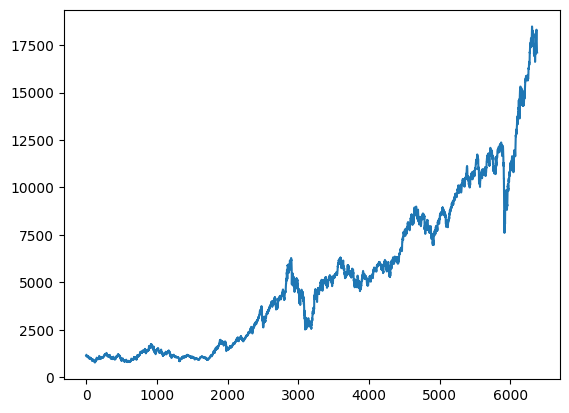

In [20]:
import matplotlib.pyplot as plt
plt.plot(data_set_1.Close)

#Date vs Close price

In [21]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
data_set_scaled_1 = sc.fit_transform(data_set_1)
print(data_set_scaled_1)

[[0.01967279 0.01900877 0.02045459 ... 0.00950252 0.00488744 0.02006399]
 [0.01972218 0.01909473 0.0204495  ... 0.00963711 0.00502275 0.02124044]
 [0.02124273 0.02051787 0.02196677 ... 0.00979403 0.00517338 0.02149653]
 ...
 [0.91014808 0.92722474 0.90896934 ... 0.99964866 0.99981748 0.92272555]
 [0.9135411  0.92010902 0.91066431 ... 0.99935326 0.99991274 0.92226198]
 [0.92175283 0.93084018 0.92256876 ... 0.99905386 1.         0.93439954]]


In [22]:
data_set_scaled_1.shape

(6380, 9)

In [23]:
data_set_scaled_1[0:, 8].shape

(6380,)

In [24]:
# multiple feature from data provided to the model
X1 = []
#print(data_set_scaled[0].size)
#data_set_scaled=data_set.values
backcandles = 30
print(data_set_scaled_1.shape[0])

for j in range(8):#data_set_scaled[0].size):#2 columns are target not X
    X1.append([])
    for i in range(backcandles, data_set_scaled_1.shape[0]):#backcandles+2
        X1[j].append(data_set_scaled_1[i-backcandles:i, j])

#move axis from 0 to position 2
X1=np.moveaxis(X1, [0], [2])

#Erase first elements of y because of backcandles to match X length
#del(yi[0:backcandles])
#X, yi = np.array(X), np.array(yi)
# Choose -1 for last column, classification else -2...
X1, yi1 =np.array(X1), np.array(data_set_scaled_1[backcandles:,-1])
y1=np.reshape(yi1,(len(yi1),1))
#y=sc.fit_transform(yi)
#X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X1)
print(X1.shape)
print(y1)
print(y1.shape)

6380
[[[0.01967279 0.01900877 0.02045459 ... 0.0156909  0.00950252 0.00488744]
  [0.01972218 0.01909473 0.0204495  ... 0.01590585 0.00963711 0.00502275]
  [0.02124273 0.02051787 0.02196677 ... 0.01621558 0.00979403 0.00517338]
  ...
  [0.01687811 0.01753674 0.0176368  ... 0.01577762 0.01178218 0.00759256]
  [0.01811857 0.01799689 0.01888752 ... 0.01584927 0.01184235 0.00767198]
  [0.01866583 0.01802892 0.01906749 ... 0.01591737 0.01190203 0.00775084]]

 [[0.01972218 0.01909473 0.0204495  ... 0.01590585 0.00963711 0.00502275]
  [0.02124273 0.02051787 0.02196677 ... 0.01621558 0.00979403 0.00517338]
  [0.02132917 0.0205926  0.02202789 ... 0.0165209  0.00995328 0.00532576]
  ...
  [0.01811857 0.01799689 0.01888752 ... 0.01584927 0.01184235 0.00767198]
  [0.01866583 0.01802892 0.01906749 ... 0.01591737 0.01190203 0.00775084]
  [0.01905256 0.01805251 0.01922085 ... 0.01599061 0.01196305 0.00783037]]

 [[0.02124273 0.02051787 0.02196677 ... 0.01621558 0.00979403 0.00517338]
  [0.02132917 0.0

In [25]:
# split data into train test sets
splitlimit = int(len(X1)*0.8)
print(splitlimit)
X_train1, X_test1 = X1[:splitlimit], X1[splitlimit:]
y_train1, y_test1 = y1[:splitlimit], y1[splitlimit:]
print(X_train1.shape)
print(X_test1.shape)
print(y_train1.shape)
print(y_test1.shape)
print(y_train1)

5080
(5080, 30, 8)
(1270, 30, 8)
(5080, 1)
(1270, 1)
[[0.01718535]
 [0.0159015 ]
 [0.0155199 ]
 ...
 [0.42024377]
 [0.41801921]
 [0.41638824]]


In [26]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import numpy as np
#tf.random.set_seed(20)
np.random.seed(10)

lstm_input = Input(shape=(backcandles, 8), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train1, y=y_train1, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
305/305 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0012 - val_loss: 8.0849e-05
Epoch 2/30
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.2591e-05 - val_loss: 6.3450e-05
Epoch 3/30
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.2695e-05 - val_loss: 7.6058e-04
Epoch 4/30
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.7231e-05 - val_loss: 8.0764e-05
Epoch 5/30
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.4328e-05 - val_loss: 7.1563e-05
Epoch 6/30
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.2221e-05 - val_loss: 6.0647e-05
Epoch 7/30
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.2099e-05 - val_loss: 5.6577e-05
Epoch 8/30
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.4569e-05 - val_loss: 1.7851e-04
Epoch 9/30
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.1476e-05 - val_loss: 8.5534e-05
Epoch 10/30
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.0985e-05 - val_loss: 5.3971e-05
Epoch 11/30
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.

In [27]:
y_pred = model.predict(X_test1)
#y_pred=np.where(y_pred > 0.43, 1,0)
for i in range(10):
    print(y_pred[i], y_test1[i])

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
[0.41351765] [0.41558831]
[0.41167393] [0.41360401]
[0.41163307] [0.41236312]
[0.40867752] [0.41117028]
[0.40770894] [0.4065233]
[0.4066721] [0.40689924]
[0.40057647] [0.40251796]
[0.40200788] [0.40956193]
[0.3963306] [0.40967499]
[0.40776545] [0.41356161]


In [28]:
y_pred.shape

(1270, 1)

In [29]:
y_test1.shape

(1270, 1)

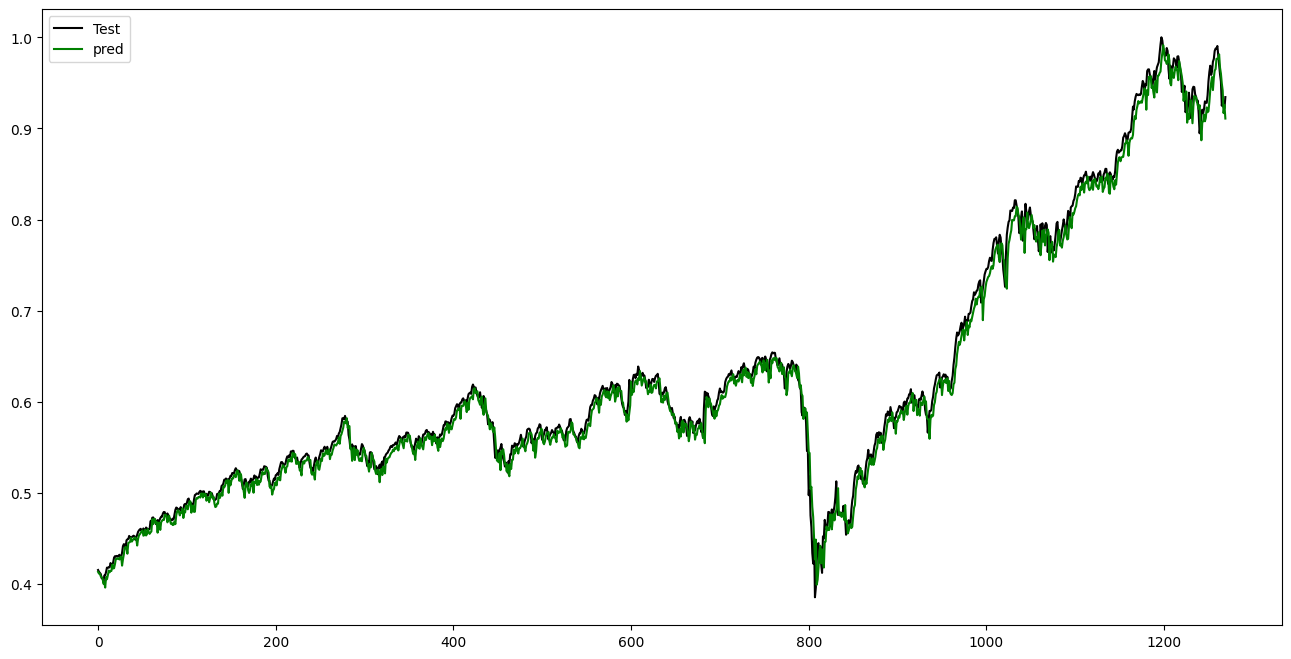

In [30]:
plt.figure(figsize=(16,8))
plt.plot(y_test1, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'green', label = 'pred')
plt.legend()
plt.show()

In [31]:
def back_track(initial_amount_given, close_pred, actual_day_close, days ):
    #print(f"Initial amount given: {initial_amount_given}")
    if len(close_pred) != len(actual_day_close):
        raise Exception("What the hell!")
    
    profit=0
    number_of_stocks = 0
    money_not_invested= initial_amount_given
    for day in range(days-1):
        #buy on day 0
        if day == 0 and False:
            profit=0
            number_of_stocks= money_not_invested//actual_day_close[0]
            last_stock_buy_price=actual_day_close[0]
            money_not_invested-= number_of_stocks * actual_day_close[0]
            continue
        
        #day 2
        if number_of_stocks == 0:
            if actual_day_close[day] < close_pred[day+1]:
                #buy
                #print(f"Buying on day {day}")
                number_of_stocks= money_not_invested//actual_day_close[day]
                last_stock_buy_price=actual_day_close[day]
                money_not_invested-= number_of_stocks * actual_day_close[day]
            
        elif actual_day_close[day] > close_pred[day+1]:
            #sell
            #print(f"Selling on day {day}")
            money_not_invested+= actual_day_close[day] * number_of_stocks
            profit_on_this=(actual_day_close[day] - last_stock_buy_price) * number_of_stocks
            number_of_stocks=0
            #print(f"Profit on day {day}: {profit_on_this}")
            profit += profit_on_this
            
        elif actual_day_close[day] <= close_pred[day+1]:
            #print(f"Holding on day {day}")
            pass
    
    #last day
    #sell
    profit_on_this=(actual_day_close[day] - last_stock_buy_price) * number_of_stocks
    profit += profit_on_this
    return initial_amount_given + profit
            
            
initial_amount = 10000
predicted_close_prices = [110, 105, 95, 100, 120]  # Example predicted closing prices for 5 days
actual_close_prices =    [105, 100, 90, 110, 115]     # Example actual closing prices for 5 days

final_amount = back_track(initial_amount, predicted_close_prices, actual_close_prices, 5)
print(f"Final amount after backtracking: {final_amount}")
print(f"Profit generated: {final_amount- initial_amount}")


Final amount after backtracking: 12220
Profit generated: 2220


In [33]:
y_pred
y_test1

initial_amount = 10000
days= 500


final_amount_lst=[]
for i in range(days):
    final_amount = back_track(initial_amount, y_pred[i:], y_test1[i:], days)
    #print(f"Final amount after backtracking: {final_amount}")
    #print(f"Profit generated: {final_amount- initial_amount}")
    final_amount_lst.append(float(final_amount[0]))
    


max_p = np.max(final_amount_lst)
day = final_amount_lst.index(max_p)+1
print(f"profit max: {max_p-initial_amount} at day {day}")
min_p = np.min(final_amount_lst)
day = final_amount_lst.index(min_p)+1
print(f"profit min: {min_p-initial_amount} at day {day}")

    



profit max: 4029.878819485666 at day 481
profit min: -1050.1815714939803 at day 308
